# Bayesian Networks: ELISA

A [GraViz installation](https://graphviz.org/download/) is needed to view the graphic outputs in this notebook

In [19]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import util.extensions

%matplotlib inline 

> People are bad at reasoning intuitively about probabilities. 
> Convince yourself by solving the following exercise.
> ELISA is a search test for HIV with sensitivity p(positive|HIV) = 0.99
> and specificity p(negative|¬HIV) = 0.98. Guess the probability
> p(HIV|positive) of being HIV infected given a positive test result.

In [20]:
net_name = 'ELISA Example'
bn = gum.BayesNet(net_name)

## Define Random Variables

In [21]:
H = bn.add(gum.LabelizedVariable('HIV','H', 2))
E = bn.add(gum.LabelizedVariable('ELISA','E', 2))

In [22]:
# HIV (H) is conditional on Postive (P)
bn.addArc(H, E)

## Define Probability Distribution for each Node

[Adult HIV Prevalence in Switzerland:](https://en.wikipedia.org/wiki/List_of_countries_by_HIV/AIDS_adult_prevalence_rate) 

$P(HIV) = 0.5\%$

In [23]:
bn.cpt(H).fillWith([0.995, 0.005])

(gum::Potential<double>@0x55c30a7bafe0) <HIV:0> :: 0.995 /<HIV:1> :: 0.005

In [29]:
bn.cpt(E)[{'HIV': 1}] = [0.01, 0.99]
bn.cpt(E)[{'HIV': 0}] = [0.98, 0.02]
bn.cpt(E)

(gum::Potential<double>@0x55c30aca1f10) <ELISA:0|HIV:0> :: 0.98 /<ELISA:1|HIV:0> :: 0.02 /<ELISA:0|HIV:1> :: 0.01 /<ELISA:1|HIV:1> :: 0.99

## Display Bayesian Network

In [30]:
print(bn)

BN{nodes: 2, arcs: 1, domainSize: 4, dim: 6}


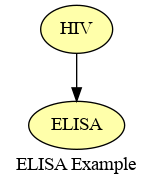

In [31]:
bn.display()

In [32]:
bn.display_tables()

## Inference

In [33]:
# Enables exact inference
ie = gum.LazyPropagation(bn)

### 1/ Global Probability Distribution

It follows from the Bayesian network structure that

$p(HIV, ELISA) = p(ELISA | HIV) \cdot p(HIV)$

Note, calculating the global distribution takes exponential time and space - do not do this for larger examples!

In [34]:
ie.addJointTarget(bn.nodes())
ie.makeInference()
glob = ie.jointPosterior(bn.nodes())
glob

(gum::Potential<double>@0x55c30aa57060) <HIV:0|ELISA:0> :: 0.9751 /<HIV:1|ELISA:0> :: 5e-05 /<HIV:0|ELISA:1> :: 0.0199 /<HIV:1|ELISA:1> :: 0.00495

### 3/ Conditional Distribution

Calculate the probability of HIV given a positive ELISA test

$p(HIV | ELISA) = \frac{p(ELISA | HIV) \cdot p(HIV)}{p(ELISA)}$

In [35]:
target = H
ie.addTarget(target)
ie.setEvidence({'ELISA' : 1}) # Positive ELISA test
ie.makeInference()
ie.posterior(target)

(gum::Potential<double>@0x55c309b59110) <HIV:0> :: 0.800805 /<HIV:1> :: 0.199195

Let us verify this result by hand: It follows from the Bayesian network structure and bayes theorem, that

$p(HIV | ELISA) = \frac{p(ELISA | HIV) \cdot p(HIV)}{p(ELISA)} = \frac{p(ELISA | HIV) \cdot p(HIV)}{\sum_{HIV} p(ELISA | HIV) \cdot p(HIV)}
= \frac{0.99 \cdot 0.005}{0.99 \cdot 0.005 + 0.02 \cdot 0.995}$

In [36]:
numerator = (0.99 * 0.005)
print("numerator:\t {:.6f}".format(numerator))

denominator = (0.99 * 0.005 +
               0.02 * 0.995)
               
print("denominator:\t {:.6f}".format(denominator))

result = numerator / denominator

# Compare visually
print("result:\t\t {:.6f}".format(result))

# Compare automatically
assert np.isclose(result, ie.posterior(H)[1])

numerator:	 0.004950
denominator:	 0.024850
result:		 0.199195


#### Recalculation for Botswana with $p(HIV) = 40\%$

In [37]:
bn.cpt(H).fillWith([0.60, 0.40])

(gum::Potential<double>@0x55c30a7bafe0) <HIV:0> :: 0.6 /<HIV:1> :: 0.4

In [38]:
target = H
ie.addTarget(target)
ie.setEvidence({'ELISA' : 1}) # Positive ELISA test
ie.makeInference()
ie.posterior(target)

(gum::Potential<double>@0x55c30ac075b0) <HIV:0> :: 0.0294118 /<HIV:1> :: 0.970588

#### Interpretation

Intuitively we would think, that if a test like ELISA with high sensitivity and specificity returns positive, then the probability of that result being correct should be high. But depending on the prior probability of HIV the probability of having HIV with a positive ELISA can either be pretty low (Switzerland) or rather high (Botswana). This also explains why the same test cannot be used in different parts of the world.